
# 量化交易入门

本笔记本提供量化交易的基本概念和Python实现方法。通过跟随这个教程，您将了解：

- 量化交易的基本概念
- 市场数据的获取和处理
- 技术指标的计算和可视化
- 简单交易策略的实现
- 基本的回测方法



## 环境设置

首先导入必要的库和工具：


In [12]:
# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta


# 设置绘图样式
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# 显示所有列
pd.set_option('display.max_columns', None)



## 获取市场数据

使用yfinance库从Yahoo Finance获取股票数据：


In [13]:
import yfinance as yf

ticker_symbol = "TSLA"

# # 下载数据，虽然指定了 group_by='column'，返回的依然是 MultiIndex 列
# stock_data = yf.download(ticker_symbol, start="2022-03-01", end="2025-02-28", group_by='column')
# print("原始数据：")
# print(stock_data.head())

# # 将 MultiIndex 列扁平化：取第一层作为新的列标签
# stock_data.columns = stock_data.columns.get_level_values(0)
# print("扁平化后的数据：")
# print(stock_data.head())

# # 保存为 CSV 文件
# stock_data.to_csv(f"{ticker_symbol}_past_year_stock_data.csv")
stock_data = pd.read_csv("TSLA_past_year_stock_data.csv", index_col=0, parse_dates=True)
print(f"{ticker_symbol} past 1 year stock data downloaded and saved to CSV file.")


TSLA past 1 year stock data downloaded and saved to CSV file.



## 数据探索和可视化

了解数据的基本特征并进行可视化：


In [14]:
# 查看数据基本信息
print("数据形状:", stock_data.shape)
print("\n数据类型:")
print(stock_data.dtypes)
print("\n基本统计信息:")
stock_data.describe()


数据形状: (753, 5)

数据类型:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

基本统计信息:


,Close,High,Low,Open,Volume
count,753.000000,753.000000,753.000000,753.000000,7.530000e+02
mean,240.163674,245.699535,234.704555,240.414786,1.060226e+08
std,66.502919,68.307310,64.859329,66.850968,3.971194e+07
min,108.099998,111.750000,101.809998,103.000000,3.716760e+07
25%,189.979996,194.199997,185.429993,189.160004,7.701320e+07
50%,233.190002,238.653336,227.279999,233.666672,9.886660e+07
75%,268.209991,275.119995,262.470001,270.070007,1.254056e+08
max,479.859985,488.540009,457.510010,475.899994,3.065906e+08


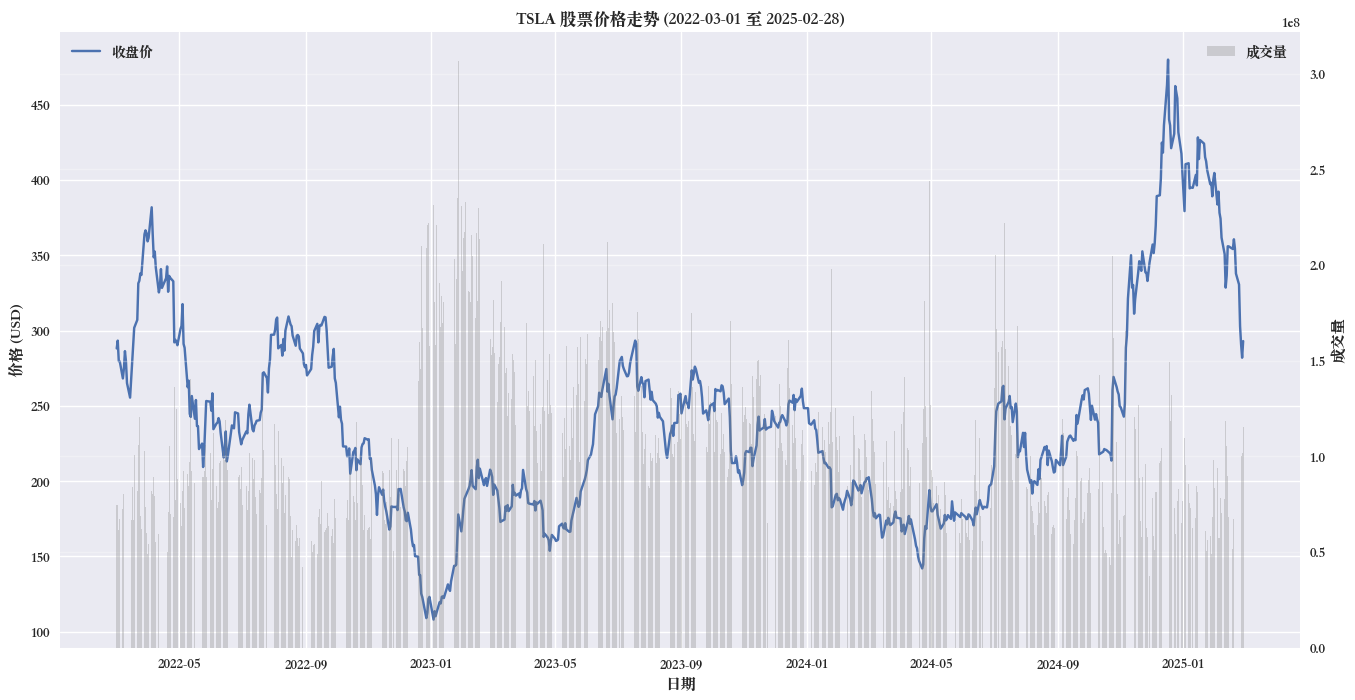

In [15]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Songti SC']
plt.rcParams['axes.unicode_minus'] = False
# for f in fm.fontManager.ttflist:
#     # 只打印名称中包含 'PingFang' 或 'SC' 或 'Hei' 等关键字的字体
#     if "PingFang" in f.name or "Heiti" in f.name or "Songti" in f.name or "SC" in f.name:
#         print(f.name)

start_date = stock_data.index[0]
end_date = stock_data.index[-1]

plt.figure(figsize=(16, 8))


plt.plot(stock_data.index, stock_data['Close'], label='收盘价')  # 绘制收盘价
ax1 = plt.gca()  # 获取当前坐标轴对象作为主轴，绘制股价折线图 get current axis
ax2 = ax1.twinx()  # 创建次坐标轴，用于绘制成交量柱状图
ax2.bar(stock_data.index, stock_data['Volume'], alpha=0.3, color='gray', label='成交量')  # 在次坐标轴绘制成交量柱状图，设置透明度和颜色
ax2.set_ylabel('成交量')  # 次坐标轴的Y轴标签

plt.title(f'{ticker_symbol} 股票价格走势 ({start_date.date()} 至 {end_date.date()})')  # 绘制标题，显示股票代码及起止日期

# 主坐标轴X、Y轴标签
ax1.set_xlabel('日期')
ax1.set_ylabel('价格 (USD)')

ax1.legend(loc='upper left')  # 在主坐标轴绘制图例，显示在左上角
ax2.legend(loc='upper right')  # 在次坐标轴绘制图例，显示在右上角


plt.grid(True, alpha=0.3)  # 启用网格，增加可读性，设置网格透明度
plt.show()  # 绘制图表



## 计算技术指标

计算常用的技术分析指标：


In [16]:

# 计算移动平均线
stock_data['SMA20'] = stock_data['Close'].rolling(window=20).mean()  # 20日简单移动平均线
stock_data['SMA50'] = stock_data['Close'].rolling(window=50).mean()  # 50日简单移动平均线
stock_data['SMA200'] = stock_data['Close'].rolling(window=200).mean()  # 200日简单移动平均线

# 计算相对强弱指数 (RSI)
period=14
delta = stock_data['Close'].diff()

# 分离涨跌幅
gain = delta.clip(lower=0)         # 涨幅为正，其余为0
loss = -delta.clip(upper=0)        # 跌幅取绝对值，其余为0
# 使用 Wilder 平滑：alpha=1/period，min_periods=period，adjust=False
avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
# 计算RS及RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
stock_data['RSI14'] = rsi

# 计算布林带
rolling_std = stock_data['Close'].rolling(window=20).std()
stock_data['BB_middle'] = stock_data['Close'].rolling(window=20).mean()
stock_data['BB_upper'] = stock_data['BB_middle'] + (rolling_std * 2)
stock_data['BB_lower'] = stock_data['BB_middle'] - (rolling_std * 2)


# 显示带有技术指标的数据
stock_data.tail()


,Close,High,Low,Open,Volume,SMA20,SMA50,SMA200,RSI14,BB_middle,BB_upper,BB_lower
Date,,,,,,,,,,,,
2025-02-24,330.529999,342.399994,324.700012,338.140015,76052300,367.206999,399.510999,276.38635,34.993528,367.206999,416.364326,318.049672
2025-02-25,302.799988,328.890015,297.250000,327.019989,134228800,362.489499,397.547198,277.01130,28.872446,362.489499,417.328377,307.650620
2025-02-26,290.799988,309.000000,288.040009,303.709991,100118300,357.124998,394.867798,277.59170,26.696210,357.124998,417.963215,296.286782
2025-02-27,281.950012,297.230011,280.880005,291.160004,101748200,351.767499,392.144799,278.14160,25.188328,351.767499,419.257758,284.277239
2025-02-28,292.980011,293.880005,273.600006,279.500000,115397200,346.402499,389.279799,278.76415,30.460249,346.402499,414.709521,278.095478


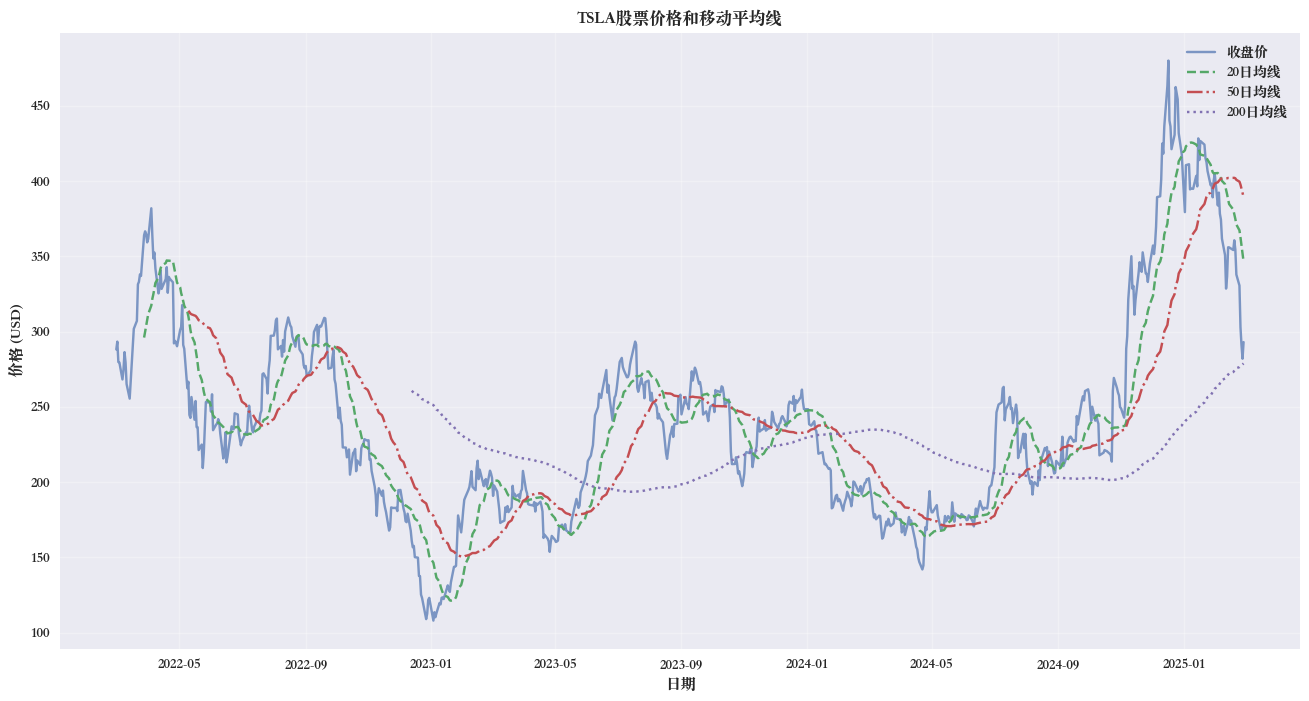

In [17]:

# 绘制带有移动平均线的股票价格图
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA20'], label='20日均线', linestyle='--')
plt.plot(stock_data.index, stock_data['SMA50'], label='50日均线', linestyle='-.')
plt.plot(stock_data.index, stock_data['SMA200'], label='200日均线', linestyle=':')

plt.title(f'{ticker_symbol}股票价格和移动平均线')
plt.xlabel('日期')
plt.ylabel('价格 (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


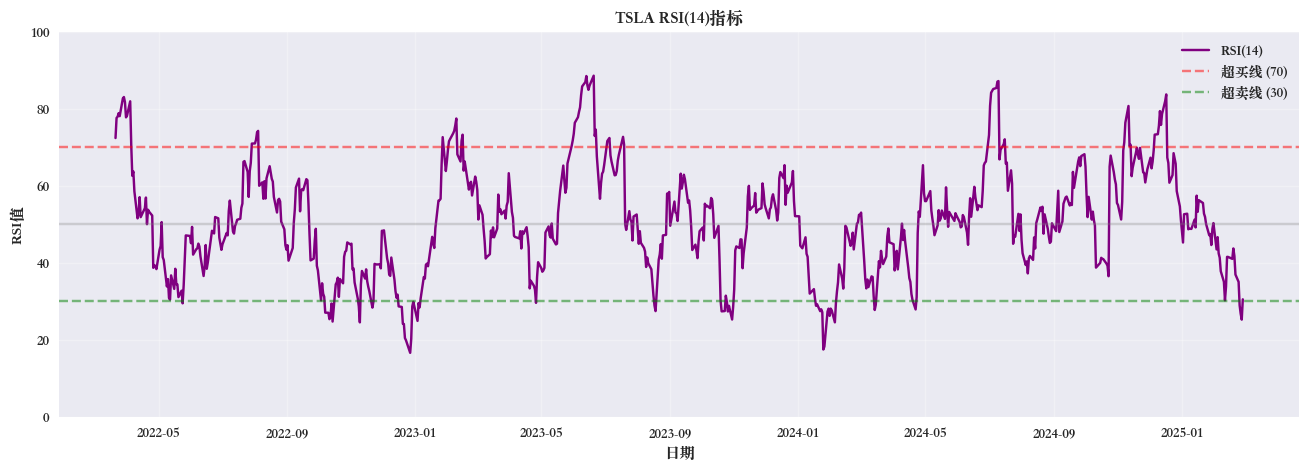

In [18]:

# 绘制RSI指标
plt.figure(figsize=(16, 5))
plt.plot(stock_data.index, stock_data['RSI14'], label='RSI(14)', color='purple')

# 添加超买超卖区域
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='超买线 (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='超卖线 (30)')
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.3)

plt.title(f'{ticker_symbol} RSI(14)指标')
plt.xlabel('日期')
plt.ylabel('RSI值')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.show()


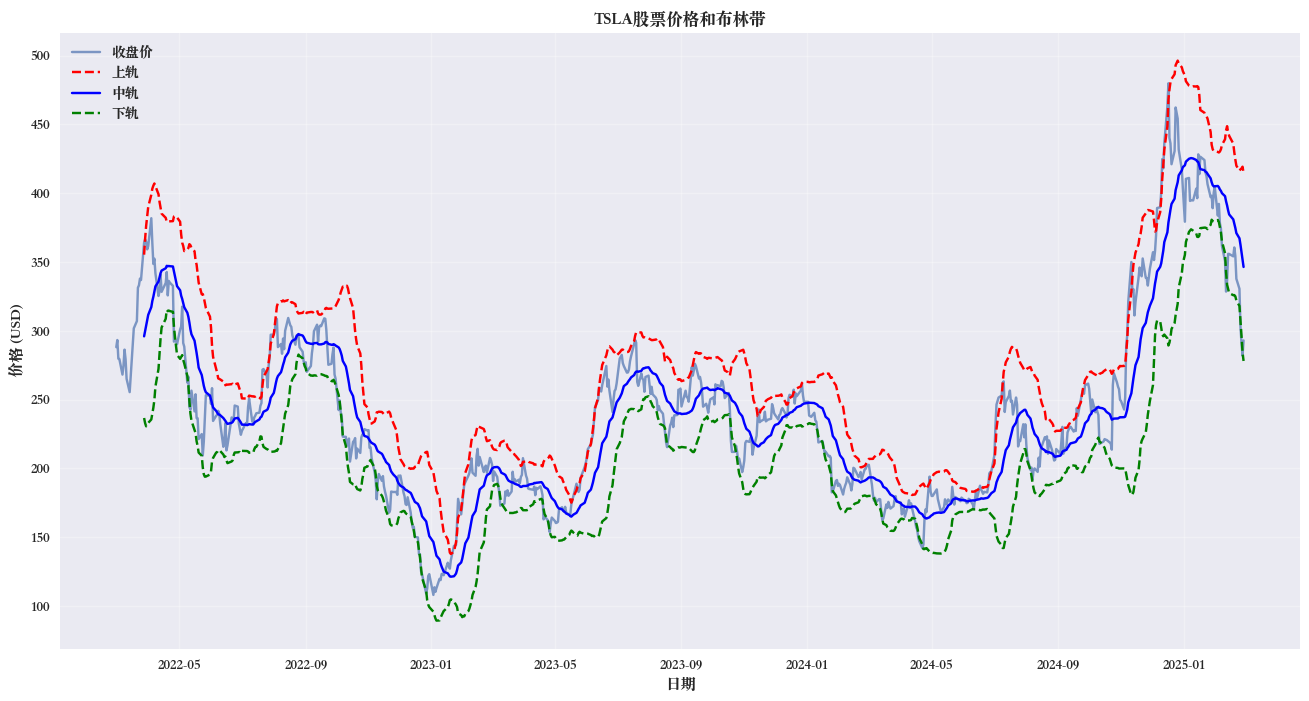

In [20]:

# 绘制布林带
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)
plt.plot(stock_data.index, stock_data['BB_upper'], label='上轨', color='red', linestyle='--')
plt.plot(stock_data.index, stock_data['BB_middle'], label='中轨', color='blue', linestyle='-')
plt.plot(stock_data.index, stock_data['BB_lower'], label='下轨', color='green', linestyle='--')

plt.title(f'{ticker_symbol}股票价格和布林带')
plt.xlabel('日期')
plt.ylabel('价格 (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 简单策略实现

实现一个基于移动平均线交叉的简单交易策略：


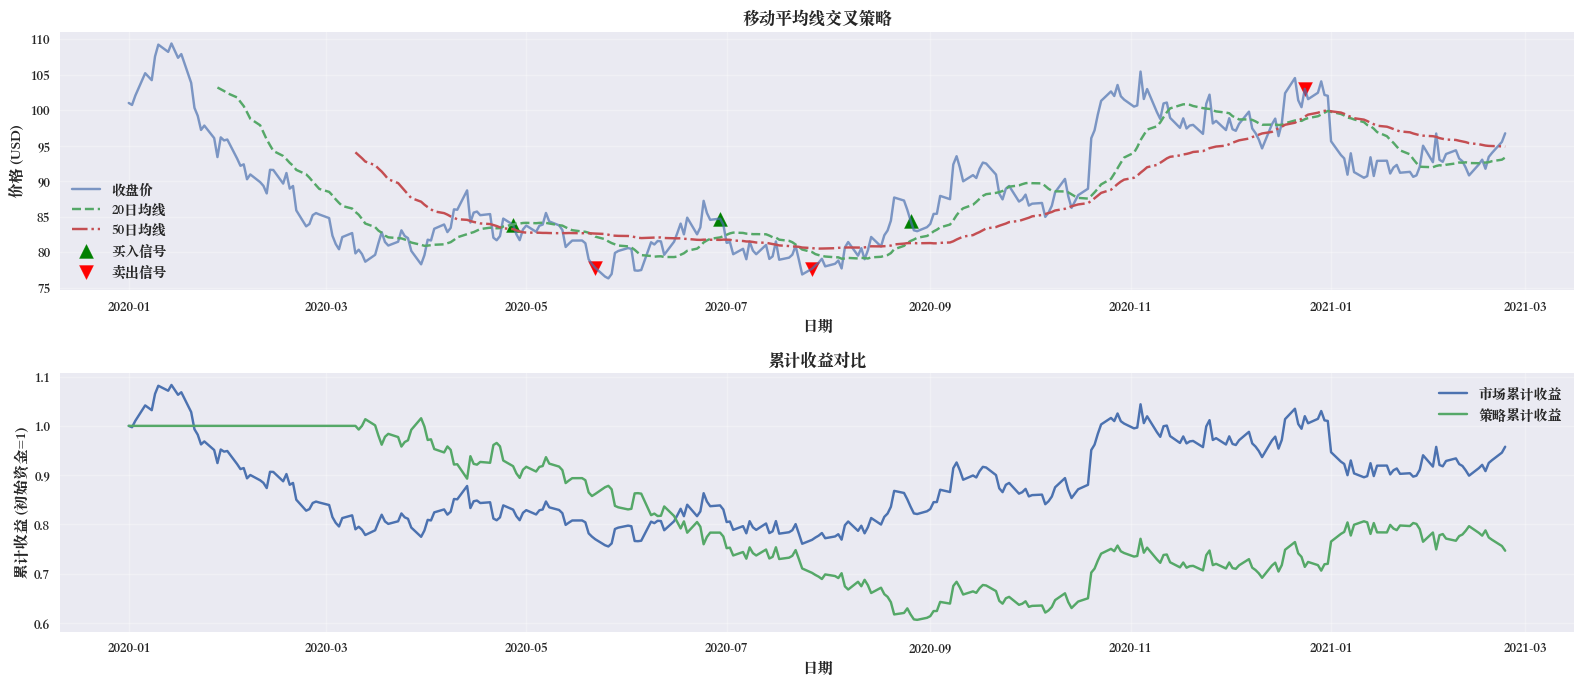

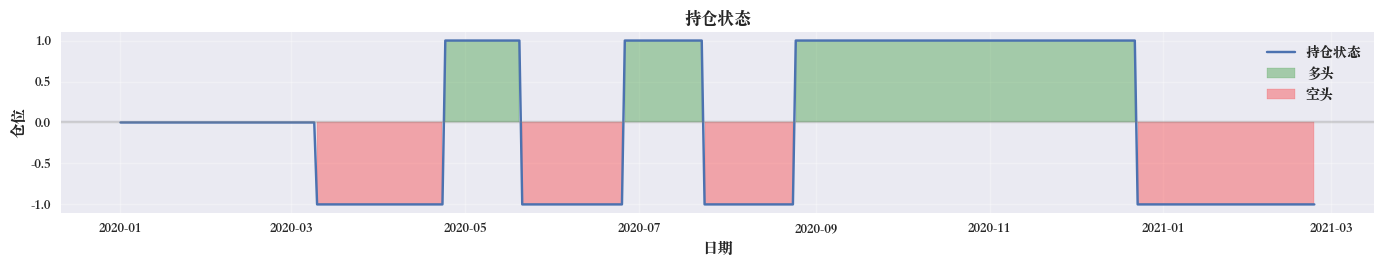

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 生成模拟数据（使用随机游走模拟股票收盘价）
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=300, freq='B')
# 生成对数正态随机数据并累计作为价格
prices = np.random.lognormal(mean=0, sigma=0.02, size=len(dates)).cumprod() * 100
stock_data = pd.DataFrame({'Close': prices}, index=dates)

# 计算短期（20日）和长期（50日）移动平均线
stock_data['SMA_Fast'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_Slow'] = stock_data['Close'].rolling(window=50).mean()

# 根据均线交叉生成原始信号：20日均线大于50日均线时信号为1（买入），反之为-1（卖出）
stock_data['Signal'] = 0
stock_data.loc[stock_data['SMA_Fast'] > stock_data['SMA_Slow'], 'Signal'] = 1
stock_data.loc[stock_data['SMA_Fast'] < stock_data['SMA_Slow'], 'Signal'] = -1

# 为避免当日已知收盘价就进行交易，将信号延迟一天，模拟“下一日开盘”交易
stock_data['Trade_Signal'] = stock_data['Signal'].shift(1)

# 计算市场的日收益率（基于收盘价的百分比变化）
stock_data['Market_Return'] = stock_data['Close'].pct_change()

# 计算仓位变化（买卖时仓位的变化会产生交易成本）
stock_data['Position_Change'] = stock_data['Trade_Signal'].diff().abs()

# 设置交易成本比例（例如：每次交易成本为0.1%）
transaction_cost = 0.001

# 计算策略的日收益率：使用前一日的交易信号乘以当天市场收益，同时扣除因仓位变动产生的交易费用
stock_data['Strategy_Return'] = stock_data['Trade_Signal'] * stock_data['Market_Return'] - transaction_cost * stock_data['Position_Change']

# 计算累计收益，初始资金设为1
stock_data['Cumulative_Market'] = (1 + stock_data['Market_Return'].fillna(0)).cumprod()
stock_data['Cumulative_Strategy'] = (1 + stock_data['Strategy_Return'].fillna(0)).cumprod()

# 绘制结果
plt.figure(figsize=(16, 10))

# 子图1：收盘价、均线及买卖信号标记
plt.subplot(3, 1, 1)
plt.plot(stock_data.index, stock_data['Close'], label='收盘价', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA_Fast'], label='20日均线', linestyle='--')
plt.plot(stock_data.index, stock_data['SMA_Slow'], label='50日均线', linestyle='-.')
# 计算交易信号的变化，便于标记买入卖出点（当 Trade_Signal 从 -1 跃变到 1，diff 为2；反之为-2）
stock_data['Trade_Change'] = stock_data['Trade_Signal'].diff()
buy_signals = stock_data[stock_data['Trade_Change'] == 2].index
sell_signals = stock_data[stock_data['Trade_Change'] == -2].index

plt.scatter(buy_signals, stock_data.loc[buy_signals, 'Close'], marker='^', color='g', s=100, label='买入信号')
plt.scatter(sell_signals, stock_data.loc[sell_signals, 'Close'], marker='v', color='r', s=100, label='卖出信号')
plt.title('移动平均线交叉策略')
plt.xlabel('日期')
plt.ylabel('价格 (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：累计收益对比（市场 vs 策略）
plt.subplot(3, 1, 2)
plt.plot(stock_data.index, stock_data['Cumulative_Market'], label='市场累计收益')
plt.plot(stock_data.index, stock_data['Cumulative_Strategy'], label='策略累计收益')
plt.title('累计收益对比')
plt.xlabel('日期')
plt.ylabel('累计收益 (初始资金=1)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# # 绘制持仓状态
plt.subplot(3, 1, 3)
plt.plot(stock_data.index, stock_data['Signal'], label='持仓状态')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.fill_between(stock_data.index, stock_data['Signal'], 0, where=stock_data['Signal'] > 0, color='g', alpha=0.3, label='多头')
plt.fill_between(stock_data.index, stock_data['Signal'], 0, where=stock_data['Signal'] < 0, color='r', alpha=0.3, label='空头')

plt.title('持仓状态')
plt.xlabel('日期')
plt.ylabel('仓位')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




## 策略回测

计算策略的收益和评估指标：


In [23]:
import numpy as np

# 选择有效数据（去除NaN）
valid_data = stock_data.dropna()

# 计算年化收益率
total_days = (valid_data.index[-1] - valid_data.index[0]).days
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1

# 计算波动率（标准差）
daily_vol_strategy = valid_data['Strategy_Return'].std()
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)  # 假设一年252个交易日

daily_vol_market = valid_data['Market_Return'].std()  # 使用计算好的市场日收益率
annual_vol_market = daily_vol_market * np.sqrt(252)

# 计算夏普比率（假设无风险收益率为0）
sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy
sharpe_ratio_market = annual_return_market / annual_vol_market

# 计算最大回撤
cumulative_returns_strategy = valid_data['Cumulative_Strategy']
running_max_strategy = cumulative_returns_strategy.cummax()
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy
max_drawdown_strategy = drawdown_strategy.min()

cumulative_returns_market = valid_data['Cumulative_Market']
running_max_market = cumulative_returns_market.cummax()
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market
max_drawdown_market = drawdown_market.min()

# 打印结果
print(f"评估时间段: {valid_data.index[0].date()} 至 {valid_data.index[-1].date()}")
print(f"总交易天数: {len(valid_data)}")
print("\n--- 策略表现 ---")
print(f"年化收益率: {annual_return_strategy:.2%}")
print(f"年化波动率: {annual_vol_strategy:.2%}")
print(f"夏普比率: {sharpe_ratio_strategy:.2f}")
print(f"最大回撤: {max_drawdown_strategy:.2%}")
print("\n--- 基准表现 (Buy & Hold) ---")
print(f"年化收益率: {annual_return_market:.2%}")
print(f"年化波动率: {annual_vol_market:.2%}")
print(f"夏普比率: {sharpe_ratio_market:.2f}")
print(f"最大回撤: {max_drawdown_market:.2%}")


评估时间段: 2020-03-10 至 2021-02-23
总交易天数: 251

--- 策略表现 ---
年化收益率: -26.25%
年化波动率: 31.50%
夏普比率: -0.83
最大回撤: -40.26%

--- 基准表现 (Buy & Hold) ---
年化收益率: -4.41%
年化波动率: 31.66%
夏普比率: -0.14
最大回撤: -14.19%



## 总结与下一步

在本笔记本中，我们学习了：

1. 如何获取和处理股票数据
2. 如何计算和可视化技术指标
3. 如何实现简单的移动平均线交叉策略
4. 如何评估策略的性能

下一步，您可以尝试：

- 优化策略参数
- 实现其他交易策略（如RSI、布林带策略等）
- 添加更多的风险管理措施
- 构建投资组合并进行资产配置

请继续查看 `02_trading_strategies.ipynb` 了解更多交易策略的实现。
